In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pathlib
import random

In [3]:
df = pd.read_csv("C:\\Users\\anush\\Downloads\\BMI\\Data\\data.csv")

In [4]:
df.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,4,37.758789,Female,1,img_4.bmp


In [17]:
df.shape

(4206, 5)

In [22]:
max(df['bmi'])

85.9870605469

In [23]:
min(df['bmi'])

17.7162162162

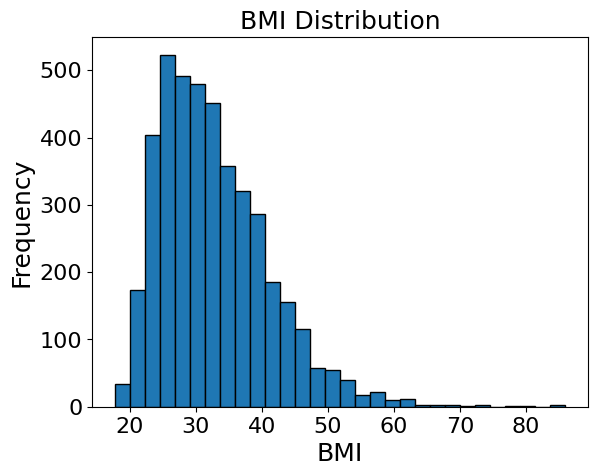

In [7]:
plt.hist(df['bmi'], bins=30, edgecolor='black')
plt.title('BMI Distribution', fontsize=18)
plt.xlabel('BMI', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [8]:
df['gender'].value_counts()

gender
Male      2438
Female    1768
Name: count, dtype: int64

In [12]:
median_bmi = df.groupby('gender')['bmi'].median()
print(median_bmi)

gender
Female    31.614201
Male      31.156007
Name: bmi, dtype: float64


C:\Users\anush\AppData\Local\Temp\ipykernel_6060\1192458732.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gender')


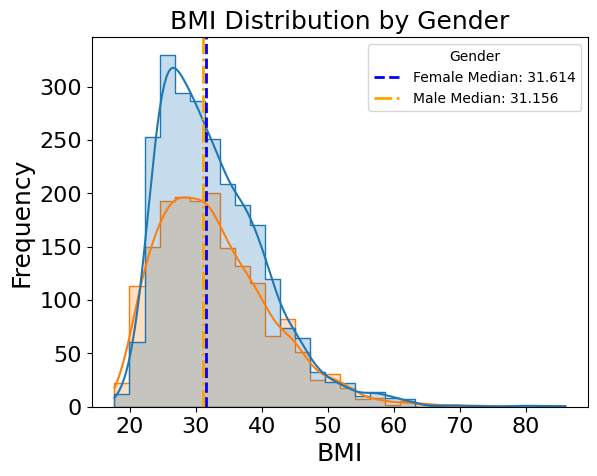

In [16]:
sns.histplot(data=df, x='bmi', hue='gender', bins=30, kde=True, element='step')
plt.title('BMI Distribution by Gender', fontsize=18)
plt.xlabel('BMI', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Gender')

# Calculate and plot median lines
medians = df.groupby('gender')['bmi'].median()

# Add vertical lines for each gender's median with different styles
plt.axvline(medians.iloc[0], linestyle='--', color='blue', label=f'{medians.index[0]} Median: {medians.iloc[0]:.3f}', linewidth=2)
plt.axvline(medians.iloc[1], linestyle='-.', color='orange', label=f'{medians.index[1]} Median: {medians.iloc[1]:.3f}', linewidth=2)


plt.legend(title='Gender')
plt.show()

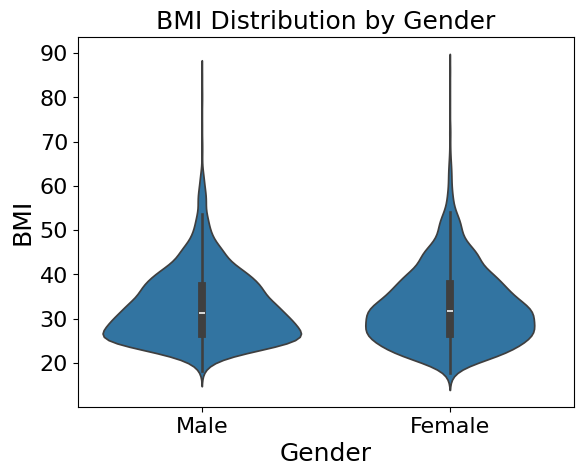

In [10]:
sns.violinplot(data=df, x='gender', y='bmi')
plt.title('BMI Distribution by Gender', fontsize=18)
plt.xlabel('Gender', fontsize=18)
plt.ylabel('BMI', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

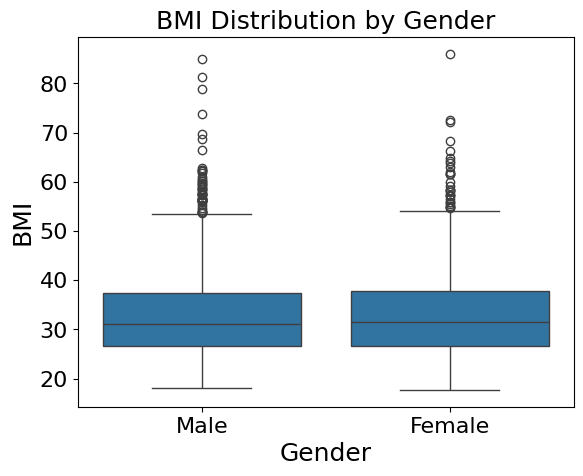

In [ ]:
sns.boxplot(data=df, x='gender', y='bmi')
plt.title('BMI Distribution by Gender', fontsize=18)
plt.xlabel('Gender', fontsize=18)
plt.ylabel('BMI', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [2]:
image_dir = pathlib.Path(r"C:\Users\anush\Downloads\BMI\Data\Images")

image_paths = list(image_dir.glob('*'))  

# Create tf.data.Dataset from image file paths
dataset = tf.data.Dataset.from_tensor_slices([str(path) for path in image_paths])

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)  
    return image

image_dataset = dataset.map(load_image)

In [27]:
image_dataset.cardinality().numpy()

np.int64(3963)

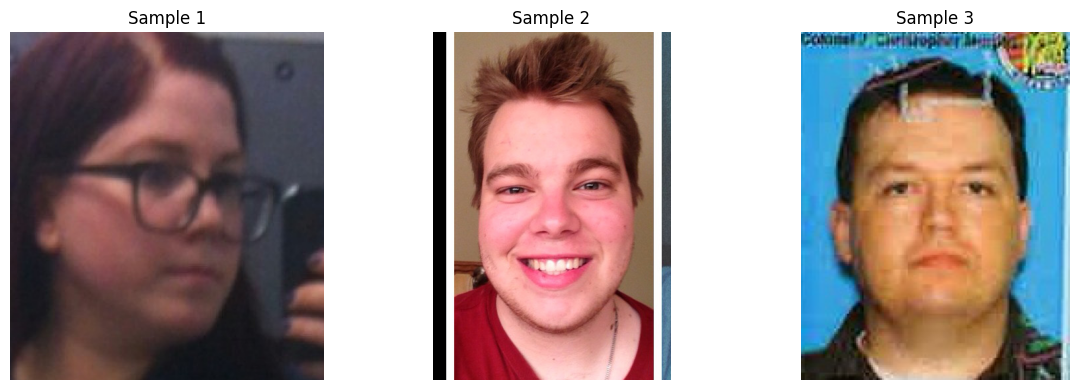

In [21]:
image_folder = r"C:\Users\anush\Downloads\BMI\Data\Images"
image_paths = list(tf.io.gfile.glob(image_folder + "/*"))

# Pick 3 random image file paths
sample_paths = random.sample(image_paths, 3)

plt.figure(figsize=(12, 4))

for i, img_path in enumerate(sample_paths):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3)

    plt.subplot(1, 3, i+1)  # 1 row, 3 columns
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Sample {i+1}")

plt.tight_layout()
plt.show()


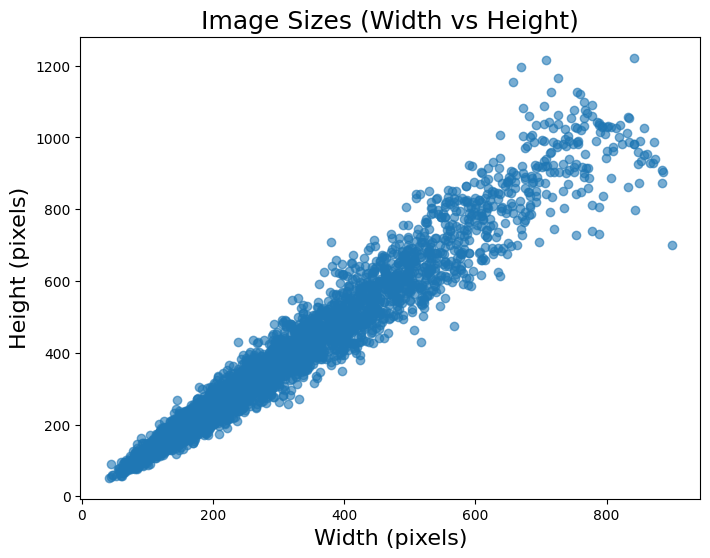

In [29]:
# Function to get image sizes
def get_image_size(image):
    shape = tf.shape(image)
    height = shape[0].numpy()
    width = shape[1].numpy()
    return width, height

widths = []
heights = []

for image in image_dataset:
    w, h = get_image_size(image)
    widths.append(w)
    heights.append(h)

plt.figure(figsize=(8,6))
plt.scatter(widths, heights, alpha=0.6)
plt.title('Image Sizes (Width vs Height)', fontsize=18)
plt.xlabel('Width (pixels)', fontsize=16)
plt.ylabel('Height (pixels)', fontsize=16)
plt.show()

In [8]:
image_folder = r"C:\Users\anush\Downloads\BMI\Data\Images"
image_paths = tf.data.Dataset.list_files(image_folder + "/*")

target_size = (224, 224)

def load_and_resize_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.uint8)
    return image

resized_dataset = image_paths.map(load_and_resize_image)

batch_size = 32
batched_dataset = resized_dataset.batch(batch_size)

hist_red = np.zeros(256)
hist_green = np.zeros(256)
hist_blue = np.zeros(256)

for batch in batched_dataset:
    batch_np = batch.numpy()
    hist_red += np.histogram(batch_np[:, :, :, 0].flatten(), bins=256, range=(0,255))[0]
    hist_green += np.histogram(batch_np[:, :, :, 1].flatten(), bins=256, range=(0,255))[0]
    hist_blue += np.histogram(batch_np[:, :, :, 2].flatten(), bins=256, range=(0,255))[0]

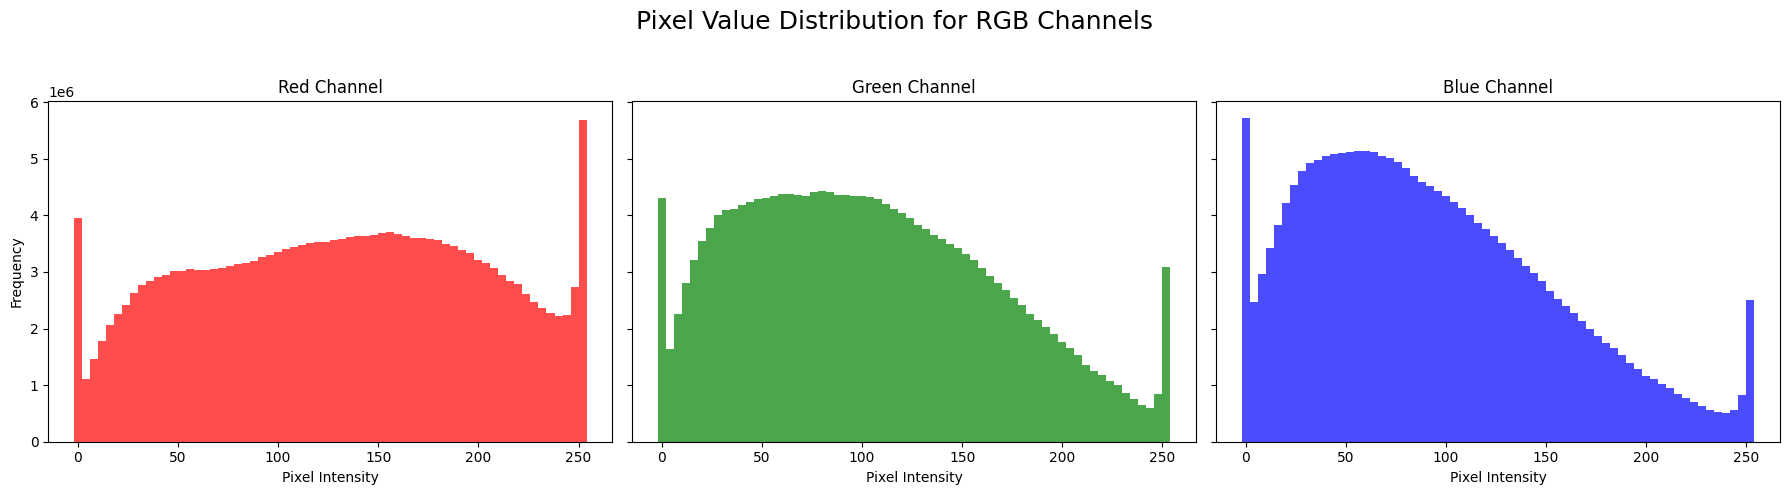

In [13]:
def rebin_hist(hist, factor=4):
    # Sum over groups of `factor` bins
    return hist.reshape(-1, factor).sum(axis=1)

bins_rebin = np.arange(0, 256, 4)  # 64 bins
hist_red_rebin = rebin_hist(hist_red)
hist_green_rebin = rebin_hist(hist_green)
hist_blue_rebin = rebin_hist(hist_blue)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].bar(bins_rebin, hist_red_rebin, color='red', alpha=0.7, width=4)
axes[0].set_title('Red Channel')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

axes[1].bar(bins_rebin, hist_green_rebin, color='green', alpha=0.7, width=4)
axes[1].set_title('Green Channel')
axes[1].set_xlabel('Pixel Intensity')

axes[2].bar(bins_rebin, hist_blue_rebin, color='blue', alpha=0.7, width=4)
axes[2].set_title('Blue Channel')
axes[2].set_xlabel('Pixel Intensity')

plt.suptitle('Pixel Value Distribution for RGB Channels', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
